## Imports and initializations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Earthquake\ Shelter\ Project

Mounted at /content/drive
/content/drive/MyDrive/Earthquake Shelter Project


In [4]:
import csv
import pickle
import datetime
from math import radians, sin, cos, sqrt, atan2
from decimal import Decimal, getcontext
getcontext().prec = 10

In [5]:
import pandas as pd
import numpy as np

import geopandas as gpd
import folium
import networkx as nx
from pyproj import Proj, transform
from scipy.stats import gaussian_kde
from scipy.spatial.distance import cdist
from shapely.geometry import Point

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

In [6]:
def read_pickle(dataset_name):
  with open('data/' + dataset_name + '.pkl', 'rb') as file_:
    return pickle.load(file_)

# Image Data

## Sentinel-1 SAR GRD: C-band Synthetic Aperture Radar Ground Range Detected, log scaling

The Sentinel-1 mission provides data from a dual-polarization C-band Synthetic Aperture Radar (SAR) instrument. SAR instruments are capable of acquiring meaningful data in all weather conditions (even clouds) during daytime and nighttime. Sentinel-1 data is used across many domains, including maritime activity, sea-ice mapping, humanitarian aid, crisis response, and forest management.

Showcase: https://code.earthengine.google.com/939cd9a03c1e7be05c3e483096cc17b4

Sentinel-1 Algorithms: https://developers.google.com/earth-engine/guides/sentinel1

## Sentinel-2 MSI: Multispectral Instrument

The Sentinel-2 mission collects high-resolution multispectral imagery useful for a broad range of applications, including monitoring of vegetation, soil and water cover, land cover change, as well as humanitarian and disaster risk.

Showcase: https://code.earthengine.google.com/62c2f6a2b6765700a830f073b05e1b4a

## Shelter Data

Source: Geospatial Information Authority of Japan https://www.gsi.go.jp/bousaichiri/hinanbasho.html

In [ ]:
shelter_locations = pd.DataFrame(columns=[
    'municipality_code', 'ward', 'num', 'name', 'address',
    'flood', 'landslide', 'storm', 'earthquake', 'tsunami', 'fire', 'inland_flooding', 'volcano',
    'address_match', # If the address corresponds to exactly the evacuation site
    'latitude', 'longitude'
])

In [ ]:
def apply_function(array, indexes, func): # absolutely brilliant
  return [func(el) if i in indexes else el for i, el in enumerate(array)]

In [ ]:
shelter_data_loc = 'data/shelter/全国指定緊急避難場所データ.csv'
with open(shelter_data_loc, 'r') as shelter_file:
  csv_reader = csv.reader(shelter_file)
  next(csv_reader)

  for row in csv_reader:
    if '東京都' in row[1]:
      row = apply_function(row[:-1], [0, 2], int)
      row = apply_function(row, [14, 15], float)
      row = apply_function(row, range(5, 14), lambda x: x == '1')

      row_df = pd.DataFrame([row], columns=shelter_locations.columns)
      bool_columns = row_df.select_dtypes(include=bool).columns
      row_df[bool_columns] = row_df[bool_columns].astype(bool)

      shelter_locations = pd.concat([shelter_locations, row_df], ignore_index=True)

<ipython-input-64-d2f864871341>:16: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  shelter_locations = pd.concat([shelter_locations, row_df], ignore_index=True)


KeyboardInterrupt: 

In [ ]:
shelter_locations

In [ ]:
shelter_locations.to_pickle('data/shelter/shelter_locations.pkl')

Source: https://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-P20.html

In [ ]:
gdf = gpd.read_file('data/shelter/2012_tokyo_locations.dbf')
gdf = gdf.rename(columns={**{
    f'P20_0{str(i + 1).zfill(2)}': el for i, el in enumerate([
        'municality_code', 'name', 'address', 'type', 'capacity', 'area', # area of shelter in square meters
        'earthquake', 'tsunami', 'water_damage', 'volcano', 'other', 'not_specified'
    ])
}, **{
    'レベル': 'level', '備考': 'notes', '緯度': 'latitude', '経度': 'longitude', 'NO': 'num'
}})

In [ ]:
boolean_cols = ['earthquake', 'tsunami', 'water_damage', 'volcano', 'other', 'not_specified']
gdf[boolean_cols] = gdf[boolean_cols].astype(bool)

In [ ]:
gdf.head()

In [ ]:
gdf.to_pickle('data/shelter/mlitt_tokyo_shelters.pkl')

In [ ]:
gdf_with_capacity = gdf[gdf['capacity'] != -1]
gdf_with_capacity.head()

In [ ]:
# @title Capacity vs Area

import matplotlib.pyplot as plt
plt.scatter(gdf_with_capacity['area'], gdf_with_capacity['capacity'])
plt.xlabel('Area')
_ = plt.ylabel('Capacity')

## Generating Test Data for Miyagi (shelters in Sendai)

In [ ]:
miyagi_data = gpd.read_file('data/shelter/2012_miyagi_locations.dbf').rename(columns={
    'P20_001': 'municipality_code', 'P20_002': 'name', 'P20_003': 'address', 'P20_004': 'type',
    'P20_005': 'capacity', 'P20_006': 'area' # area of the shelter in meters squared
})
miyagi_data_capacity = miyagi_data[miyagi_data['capacity'] != -1]
miyagi_data_capacity.head()

In [ ]:
sendai_shelters = pd.read_csv('data/shelter/sendai_shelter_list.csv')
sendai_shelters

Jakes's dataset has 189 rows and the amount of rows in common with the Miyagi dataset seem to be 182.
```python
miyagi_names = miyagi_data_capacity['name']
sendai_names = sendai_shelters['Name']

common_names = miyagi_names[miyagi_names.isin(sendai_names)]
names_not_in_miyagi = sendai_names[~sendai_names.isin(miyagi_names)].tolist()
```
However, all of Jake's rows seem to be in Miyagi dataset (Jake's names are a complete subset of the rows of the Miyagi dataset

In [ ]:
miyagi_names = miyagi_data_capacity['name']
sendai_names = sendai_shelters['Name']
common_names = miyagi_names[miyagi_names.isin(sendai_names)]
merged_df = pd.merge(miyagi_data_capacity, sendai_shelters, left_on='name', right_on='Name', how='inner')

In [ ]:
plt.figure(figsize=(16, 9))
plt.scatter(merged_df['capacity'], merged_df['Capacity'])

plt.xlabel('Capacity in MLITT Shelter Data')
plt.ylabel('Capacity in Jake Dataset')
plt.title('Comparison of Reported Shelter Capacities')
plt.show()

In [ ]:
merged_df['average_reported_capacity'] = (merged_df['capacity'] + merged_df['Capacity']) / 2
sorted_df = merged_df.sort_values(by='average_reported_capacity')

In [ ]:
plt.figure(figsize=(16, 9))

plt.scatter(merged_df['name'], merged_df['capacity'], label='MLITT Shelter Data')
plt.scatter(merged_df['Name'], merged_df['Capacity'], label='Jake Dataset')

plt.xlabel('Shelters')
plt.ylabel('Capacity')
plt.title('Dual Scatterplot of Reported Capacities')
plt.legend()
plt.xticks([])
plt.show()

```python
sns.catplot(x='name', y='capacity', data=merged_df, label='miyagi_data_capacity', height=5, aspect=2)
sns.catplot(x='Name', y='Capacity', data=merged_df, label='sendai_shelters', height=5, aspect=2)

plt.xlabel('Name')
plt.ylabel('Capacity')
plt.title('Dual Scatterplot of Capacities for Common Names')
plt.xticks([])  # Remove x-axis tick labels
plt.show()
```

In [ ]:
merged_df[['capacity', 'Capacity']].head()

In [ ]:
sns.catplot(data=merged_df[['capacity', 'Capacity']])
plt.show()

## Land Usage Subdivision Mesh (土地利用細分メッシュデータ)
https://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-L03-b-2021.html

In [ ]:
land_usage_world = gpd.read_file('data/raw_data/land_usage_100m_japan_measure.dbf')
land_usage_world.head()

In [ ]:
land_usage_codes = {
    '0100': 'rice_paddy',
    '0200': 'other_agriculture',  # fruits, vegetables, ranches, etc.
    '0500': 'forest',
    '0600': 'wasteland',
    '0700': 'building',
    '0901': 'road_transport',
    '0902': 'rail_transport',
    '1000': 'other_site',         # airports, parks, schools, etc.
    '1100': 'river_wetland',
    '1400': 'seashore',
    '1500': 'sea',
    '1600': 'gold_course',
    '0000': 'unknown'             # failed to analyze the location
}

In [ ]:
land_usage_world.shape

In [ ]:
land_usage_1km_japan = gpd.read_file('data/raw_data/land_usage_1km_japan_measure.dbf')
land_usage_1km_japan.head()

In [ ]:
land_usage_1km_japan = land_usage_1km_japan.sort_values(by='メッシュ')
land_usage_1km_japan

In [ ]:
land_use_1km_world = gpd.read_file('data/raw_data/land_usage_1km_world_measure.dbf')

In [ ]:
land_use_1km_world.sort_values(by='メッシュ')

Convert the standardized mesh codes into latitude and longitude coordinates

https://tech.atware.co.jp/mesh-system/

https://qiita.com/yuusei/items/549402a80efd7e7192ef

https://www.gis-py.com/entry/py-mesh

In [ ]:
def convert_to_latlon(mesh_code):
  # Works for 3D mesh codes only
  # Gets the bottom left corner of the mesh code
  mesh_code = str(mesh_code)

  lat = Decimal(int(mesh_code[0:2])) * Decimal(2) / Decimal(3)
  lon = Decimal(int(mesh_code[2:4])) + Decimal(100)
  lat += Decimal(int(mesh_code[4])) / Decimal(12)
  lon += Decimal(int(mesh_code[5])) / Decimal(8)
  lat += Decimal(int(mesh_code[6])) / Decimal(120)
  lon += Decimal(int(mesh_code[7])) / Decimal(80)

  return round(float(lat), 5), round(float(lon), 5)

In [ ]:
convert_to_latlon(53397799)

In [ ]:
formatted_land_use = pd.DataFrame(columns=[
    'mesh_id', 'latitude', 'longitude',                   # converted using convert_to_latlon (bottom left corner)
    'area',                                               # total area calibrated (in m2)
    'rice_paddy', 'other_agriculture', 'forest',          # categories
    'wasteland', 'building', 'road_transport',
    'rail_transport', 'other_site', 'river_wetland',
    'seashore', 'sea', 'golf_course', 'unknown'
])

In [ ]:
formatted_land_use['mesh_id'] = land_usage_1km_japan['メッシュ']
formatted_land_use[['latitude', 'longitude']] = land_usage_1km_japan['メッシュ'].apply(
    lambda x: pd.Series(convert_to_latlon(x)))
formatted_land_use['area'] = land_usage_1km_japan.iloc[:, 1:14].sum(axis=1)

In [ ]:
for i in range(1, 14):
  formatted_land_use[formatted_land_use.columns[i + 3]] = land_usage_1km_japan[land_usage_1km_japan.columns[i]] / formatted_land_use['area']

In [ ]:
formatted_land_use

In [ ]:
formatted_land_use.to_pickle('data/land_usage.pkl')

## Population Data (for 1km meshes)

作成法: https://nlftp.mlit.go.jp/ksj/gml/datalist/mesh500_1000_h30.pdf

Using survey data from 2015, they estimate every 5 years into the future by considering the number of people to turn from one age group to the next; the mortality rates of each group and the birth rates of new 0-4 year olds are also considered.

In [ ]:
pop_data = gpd.read_file('data/raw_data/population_1km.dbf')

In [ ]:
pop_data = pop_data.sort_values(by='MESH_ID')

In [ ]:
mainland_pop_data = pop_data[(53390000 <= pop_data['MESH_ID']) & (pop_data['MESH_ID'] <= 53397799)]
mainland_pop_data

,MESH_ID,SHICODE,PTN_2015,HITOKU2020,GASSAN2020,PTN_2020,PT0_2020,PT1_2020,PT2_2020,PT3_2020,...,PTB_2050,PTC_2050,PTD_2050,PTE_2050,RTA_2050,RTB_2050,RTC_2050,RTD_2050,RTE_2050,geometry
159,53392307,13209,8133.3263,None,NaN,8319.5662,8319.5662,338.1875,464.5611,462.8263,...,4213.6949,3025.5103,1906.7419,1179.0495,10.8980,51.8632,37.2388,23.4687,14.5120,None
160,53392308,13209,3263.0956,None,NaN,3345.1415,3345.1415,124.4617,158.1270,198.4912,...,1655.5099,1258.2320,807.4252,519.6333,10.8397,50.6585,38.5018,24.7072,15.9007,None
161,53392317,13209,9147.2431,None,NaN,9174.0634,9174.0634,344.9066,497.0751,509.9050,...,4365.2636,3464.2949,2226.8701,1426.9299,10.3384,49.9896,39.6720,25.5014,16.3407,None
162,53392326,13209,8092.2569,None,NaN,8231.2462,8231.2462,329.5544,525.0556,529.6717,...,4189.2760,2929.3864,1749.5744,1059.1009,11.2981,52.2003,36.5015,21.8005,13.1969,None
163,53392327,13209,12250.3348,None,NaN,12374.2156,12374.2156,427.4998,482.7561,553.5199,...,5577.1777,4287.0124,2928.3068,1991.5587,10.1661,50.7918,39.0422,26.6683,18.1373,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1532,53396107,13205,21.0371,None,NaN,17.7731,17.7731,0.1731,1.0246,0.0000,...,1.3235,4.4042,2.3956,2.3956,1.5841,22.7404,75.6755,41.1621,41.1621,None
1533,53396108,13205,2.0309,None,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,None
1534,53396112,13308,16.9579,None,NaN,15.5512,15.5512,0.4736,0.0000,0.0000,...,1.2499,4.4111,3.5085,2.6817,5.5108,20.8624,73.6267,58.5608,44.7618,None
1535,53396201,13205,194.1528,None,NaN,183.3237,183.3237,3.2116,2.0501,1.0228,...,32.8254,56.5796,43.1800,27.5569,4.4164,35.0939,60.4898,46.1641,29.4613,None


In [ ]:
pop_cols = ['MESH_ID', 'SHICODE', 'PTN_2015', 'PTN_2025', 'PTA_2025', 'PTB_2025', 'PTC_2025', 'PTD_2025', 'PTE_2025']
pop_new_cols = ['mesh_id', 'admin_code', '2015', 'total', '0-14', '15-64', '65+', '75+', '80+']
pop_data_2025 = mainland_pop_data[pop_cols]
pop_data_2025.columns = pop_new_cols[:len(pop_data_2025.columns)]

In [ ]:
pop_data_2025

,mesh_id,admin_code,2015,total,0-14,15-64,65+,75+,80+
159,53392307,13209,8133.3263,8428.9629,1125.1046,5516.7014,1787.1569,972.5568,536.7875
160,53392308,13209,3263.0956,3392.0479,416.3255,2249.2543,726.4682,392.1746,239.3943
161,53392317,13209,9147.2431,9151.1161,1192.9315,6033.2625,1924.9220,1212.4851,808.1996
162,53392326,13209,8092.2569,8307.2410,1168.1542,5368.2292,1770.8576,1078.1972,652.0640
163,53392327,13209,12250.3348,12274.6534,1340.3404,7578.0816,3356.2314,2048.7194,1272.4508
...,...,...,...,...,...,...,...,...,...
1532,53396107,13205,21.0371,15.2681,1.4179,4.0062,9.8440,6.1216,5.1849
1533,53396108,13205,2.0309,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1534,53396112,13308,16.9579,13.9130,0.7987,8.0011,5.1132,3.2897,2.3840
1535,53396201,13205,194.1528,168.2823,7.3651,75.4651,85.4520,57.0754,35.6905


In [ ]:
pop_data_2025.to_pickle('data/population_data_2025.pkl')

## Survey Population Data (for admin regions in Tokyo)

In [ ]:
survey_pop_data = gpd.read_file('data/raw_data/surveyed_population.geojson')
survey_pop_data

## Distance to Water body

In [ ]:
dist_to_water = formatted_land_use
dist_to_water

In [ ]:
mask = (dist_to_water['river_wetland'] == 0) & (dist_to_water['seashore'] == 0) & (dist_to_water['sea'] == 0)

In [ ]:
utm_proj = Proj(proj='utm', zone=54, ellps='WGS84') # This zone is for Tokyo, Japan
water_x, water_y = utm_proj(dist_to_water.loc[~mask, 'longitude'].values, dist_to_water.loc[~mask, 'latitude'].values)
check_x, check_y = utm_proj(dist_to_water.loc[mask, 'longitude'].values, dist_to_water.loc[mask, 'latitude'].values)

In [ ]:
distances = cdist(np.vstack((check_x, check_y)).T, np.vstack((water_x, water_y)).T)

In [ ]:
dist_to_water.loc[mask, 'dist_to_water'] = np.min(distances, axis=1)
dist_to_water.loc[~mask, 'dist_to_water'] = 0

In [ ]:
dist_to_water # Distance is measured in meters

In [ ]:
dist_to_water.to_pickle('data/land_usage_and_dist_to_water.pkl')

## Earthquake Data

In [ ]:
raw_earthquake_data = pd.read_csv('data/raw_data/earthquake_list.csv')
raw_earthquake_data

,地震の発生日,地震の発生時刻,震央地名,緯度,経度,深さ,Ｍ,最大震度
0,2024/03/26,16:54:27.8,石川県能登地方,37°25.0′N,137°06.0′E,9 km,3.1,震度１
1,2024/03/26,08:01:08.2,鹿児島県薩摩地方,31°50.7′N,130°47.0′E,7 km,2.8,震度１
2,2024/03/26,05:51:10.0,青森県東方沖,41°09.2′N,141°51.4′E,67 km,3.2,震度１
3,2024/03/26,03:07:51.5,能登半島沖,37°08.8′N,136°43.0′E,4 km,1.7,震度１
4,2024/03/25,23:45:29.3,鹿児島県薩摩地方,31°50.8′N,130°47.0′E,7 km,2.8,震度２
...,...,...,...,...,...,...,...,...
995,2024/01/06,05:26:51.6,石川県能登地方,37°13.0′N,136°49.9′E,12 km,5.4,震度５強
996,2024/01/06,04:53:43.3,能登半島沖,37°10.1′N,136°40.9′E,4 km,2.2,震度１
997,2024/01/06,04:46:51.2,能登半島沖,37°09.8′N,136°40.3′E,3 km,2.1,震度２
998,2024/01/06,03:47:22.6,石川県能登地方,37°10.0′N,136°42.4′E,2 km,2.1,震度１


In [ ]:
raw_earthquake_data = raw_earthquake_data[raw_earthquake_data['Ｍ'] != '不明']
raw_earthquake_data

,地震の発生日,地震の発生時刻,震央地名,緯度,経度,深さ,Ｍ,最大震度
0,2024/03/26,16:54:27.8,石川県能登地方,37°25.0′N,137°06.0′E,9 km,3.1,震度１
1,2024/03/26,08:01:08.2,鹿児島県薩摩地方,31°50.7′N,130°47.0′E,7 km,2.8,震度１
2,2024/03/26,05:51:10.0,青森県東方沖,41°09.2′N,141°51.4′E,67 km,3.2,震度１
3,2024/03/26,03:07:51.5,能登半島沖,37°08.8′N,136°43.0′E,4 km,1.7,震度１
4,2024/03/25,23:45:29.3,鹿児島県薩摩地方,31°50.8′N,130°47.0′E,7 km,2.8,震度２
...,...,...,...,...,...,...,...,...
995,2024/01/06,05:26:51.6,石川県能登地方,37°13.0′N,136°49.9′E,12 km,5.4,震度５強
996,2024/01/06,04:53:43.3,能登半島沖,37°10.1′N,136°40.9′E,4 km,2.2,震度１
997,2024/01/06,04:46:51.2,能登半島沖,37°09.8′N,136°40.3′E,3 km,2.1,震度２
998,2024/01/06,03:47:22.6,石川県能登地方,37°10.0′N,136°42.4′E,2 km,2.1,震度１


In [ ]:
def haversine_distance(coords1, coords2):
    lat1, lon1 = np.radians(coords1)
    lat2, lon2 = np.radians(coords2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371.0 * c  # Radius of the Earth in kilometers
    return km

In [ ]:
earthquake_data = pd.DataFrame(columns=[
    'recency',                                  # Decimal that represents days and hours
    'place', 'latitude', 'longitude', 'depth',  # In kilometers
    'magnitude',                                # Measured using the moment magnitude scale
    'japanese_magnitude'
])

In [ ]:
raw_earthquake_data['datetime'] = pd.to_datetime(
    raw_earthquake_data['地震の発生日'] + ' ' + raw_earthquake_data['地震の発生時刻'])

<ipython-input-18-e862c2037c84>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_earthquake_data['datetime'] = pd.to_datetime(


In [ ]:
current = datetime.datetime.now()
raw_earthquake_data['recency'] = current - raw_earthquake_data['datetime']

<ipython-input-19-cd6aa17dd2cf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_earthquake_data['recency'] = current - raw_earthquake_data['datetime']


In [ ]:
earthquake_data['recency'] = raw_earthquake_data['recency'].dt.days + raw_earthquake_data['recency'].dt.seconds / (3600 * 24)

In [ ]:
earthquake_data.to_pickle('data/tokyo/earthquake_list.pkl')

In [ ]:
earthquake_data['place'] = raw_earthquake_data['震央地名']

In [ ]:
def convert_dms_to_decimal(coordinate):
  # Works for Japan which is always north east of the equator / prime meridian
  res1 = coordinate.split('°')
  res2 = res1[-1].split('′')
  return float(res1[0]) + (float(res2[0]) / 60)

In [ ]:
earthquake_data['latitude'] = raw_earthquake_data['緯度'].apply(convert_dms_to_decimal)
earthquake_data['longitude'] = raw_earthquake_data['経度'].apply(convert_dms_to_decimal)

In [ ]:
def magnitude_to_scale(magnitude):
  magnitude = magnitude.replace('震度', '')
  if '弱' in magnitude:
    return str(int(magnitude.replace('弱', ''))) + '-'
  if '強' in magnitude:
    return str(int(magnitude.replace('強', ''))) + '+'
  return str(int(magnitude))

In [ ]:
earthquake_data['depth'] = raw_earthquake_data['深さ'].apply(lambda x: int(x.split()[0]))
earthquake_data['magnitude'] = raw_earthquake_data['Ｍ'].apply(float)
earthquake_data['japanese_magnitude'] = raw_earthquake_data['最大震度'].apply(magnitude_to_scale)

In [ ]:
earthquake_data

,recency,place,latitude,longitude,depth,magnitude,japanese_magnitude
0,1.362801,石川県能登地方,37.416667,137.100000,9,3.1,1
1,1.733171,鹿児島県薩摩地方,31.845000,130.783333,7,2.8,1
2,1.823426,青森県東方沖,41.153333,141.856667,67,3.2,1
3,1.936829,能登半島沖,37.146667,136.716667,4,1.7,1
4,2.077373,鹿児島県薩摩地方,31.846667,130.783333,7,2.8,2
...,...,...,...,...,...,...,...
995,81.840301,石川県能登地方,37.216667,136.831667,12,5.4,5+
996,81.863322,能登半島沖,37.168333,136.681667,4,2.2,1
997,81.868090,能登半島沖,37.163333,136.671667,3,2.1,2
998,81.909387,石川県能登地方,37.166667,136.706667,2,2.1,1


In [ ]:
# JMA only has data 2 days or later (so 2 is the min value)
earthquake_data['recency_normalized'] = (earthquake_data['recency'] - 2) / (earthquake_data['recency'].max() - 2)
earthquake_data['recency_normalized']

In [ ]:
# Min is a depth of 0km which is a weight of 1
earthquake_data['depth_normalized'] = earthquake_data['depth'] / earthquake_data['depth'].max()
earthquake_data['depth_normalized']

In [ ]:
# Min is a magnitude of 0
earthquake_data['magnitude_normalized'] = 10 ** (earthquake_data['magnitude'] - earthquake_data['magnitude'].max())
earthquake_data['magnitude_normalized']

In [ ]:
def weighted_kernel_density_estimation(row):
  latitude = row['latitude']
  longitude = row['longitude']

  latitudes = earthquake_data['latitude'].to_numpy()
  longitudes = earthquake_data['longitude'].to_numpy()
  # KDE weighted by normalized magntiude, recency and depth
  magnitudes = earthquake_data['magnitude_normalized'].to_numpy()
  recency = earthquake_data['recency_normalized'].to_numpy()
  depths = earthquake_data['depth_normalized'].to_numpy()

  locations = np.column_stack((latitudes, longitudes))
  distances = cdist([[latitude, longitude]], locations, haversine_distance)[0]

  magnitude_weights = magnitudes
  recency_weights = np.exp(-recency)
  depth_weights = 1 / (1 + depths)
  weights = magnitude_weights * recency_weights * depth_weights
  # Linearly normalize the weights once again
  normalized_weights = (weights - np.min(weights)) / (np.max(weights) - np.min(weights))

  kde = gaussian_kde(distances, weights=normalized_weights)
  density = kde(0)

  return density[0]

In [ ]:
magnitudes = earthquake_data['magnitude_normalized'].to_numpy()
recency = earthquake_data['recency_normalized'].to_numpy()
depths = earthquake_data['depth_normalized'].to_numpy()

magnitude_weights = magnitudes
recency_weights = np.exp(-recency)
depth_weights = 1 / (1 + depths)
weights = magnitude_weights + recency_weights + depth_weights
# Linearly normalize the weights once again
normalized_weights = (weights - np.min(weights)) / (np.max(weights) - np.min(weights))

# If outliers influence the data too much, then winsorize the data
plt.figure(figsize=(16, 9))
plt.plot(normalized_weights)
plt.show()

In [ ]:
latitude = 35.33333
longitude = 139.0000

latitudes = earthquake_data['latitude'].to_numpy()
longitudes = earthquake_data['longitude'].to_numpy()

locations = np.column_stack((latitudes, longitudes))
distances = cdist([[latitude, longitude]], locations, haversine_distance)[0]

plt.figure(figsize=(16, 9))
plt.plot(distances)
plt.show()

In [ ]:
features = read_pickle('land_usage_and_dist_to_water')

In [ ]:
features['probability'] = features.apply(weighted_kernel_density_estimation, axis=1)

In [ ]:
features

,mesh_id,latitude,longitude,area,rice_paddy,other_agriculture,forest,wasteland,building,road_transport,rail_transport,other_site,river_wetland,seashore,sea,golf_course,unknown,dist_to_water
3700,53390000,35.33333,139.0000,1050436,0.000000,0.000000,1.00,0.00,0.000000,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,1849.497063
3701,53390001,35.33333,139.0125,1050425,0.000000,0.000000,0.93,0.00,0.000000,0.00,0.0,0.00,0.00,0.0,0.0,0.07,0.0,1849.487678
3702,53390002,35.33333,139.0250,1050415,0.000000,0.000000,0.72,0.28,0.000000,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,2170.679994
3703,53390003,35.33333,139.0375,1050404,0.000000,0.000000,1.00,0.00,0.000000,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,2170.658244
3704,53390004,35.33333,139.0500,1050394,0.000000,0.000000,0.98,0.00,0.020000,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,1136.437843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,53397795,35.99167,139.9375,1041351,0.090000,0.370000,0.15,0.01,0.379999,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,1126.842641
2996,53397796,35.99167,139.9500,1041345,0.589999,0.240000,0.09,0.00,0.040000,0.00,0.0,0.04,0.00,0.0,0.0,0.00,0.0,1126.836681
2997,53397797,35.99167,139.9625,1041340,0.650000,0.100000,0.12,0.01,0.070000,0.00,0.0,0.01,0.04,0.0,0.0,0.00,0.0,0.000000
2998,53397798,35.99167,139.9750,1041334,0.220000,0.260002,0.10,0.00,0.220000,0.04,0.0,0.03,0.13,0.0,0.0,0.00,0.0,0.000000


In [ ]:
features['mesh_id'] = features['mesh_id'].apply(int)

In [ ]:
population_data = read_pickle('population_data_2025')

In [ ]:
population_data

,mesh_id,admin_code,2015,total,0-14,15-64,65+,75+,80+
159,53392307,13209,8133.3263,8428.9629,1125.1046,5516.7014,1787.1569,972.5568,536.7875
160,53392308,13209,3263.0956,3392.0479,416.3255,2249.2543,726.4682,392.1746,239.3943
161,53392317,13209,9147.2431,9151.1161,1192.9315,6033.2625,1924.9220,1212.4851,808.1996
162,53392326,13209,8092.2569,8307.2410,1168.1542,5368.2292,1770.8576,1078.1972,652.0640
163,53392327,13209,12250.3348,12274.6534,1340.3404,7578.0816,3356.2314,2048.7194,1272.4508
...,...,...,...,...,...,...,...,...,...
1532,53396107,13205,21.0371,15.2681,1.4179,4.0062,9.8440,6.1216,5.1849
1533,53396108,13205,2.0309,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1534,53396112,13308,16.9579,13.9130,0.7987,8.0011,5.1132,3.2897,2.3840
1535,53396201,13205,194.1528,168.2823,7.3651,75.4651,85.4520,57.0754,35.6905


In [ ]:
all_features = pd.merge(features, population_data, on='mesh_id', how='inner')
all_features = all_features.sort_values(by='mesh_id')
all_features

,mesh_id,latitude,longitude,area,rice_paddy,other_agriculture,forest,wasteland,building,road_transport,...,unknown,dist_to_water,admin_code,2015,total,0-14,15-64,65+,75+,80+
0,53392307,35.50000,139.4625,1047954,0.00,0.00,0.05,0.00,0.739999,0.05,...,0.0,0.000000,13209,8133.3263,8428.9629,1125.1046,5516.7014,1787.1569,972.5568,536.7875
1,53392308,35.50000,139.4750,1047946,0.00,0.15,0.04,0.00,0.680000,0.11,...,0.0,1133.933309,13209,3263.0956,3392.0479,416.3255,2249.2543,726.4682,392.1746,239.3943
2,53392317,35.50833,139.4625,1047847,0.00,0.00,0.00,0.00,0.940001,0.03,...,0.0,0.000000,13209,9147.2431,9151.1161,1192.9315,6033.2625,1924.9220,1212.4851,808.1996
3,53392326,35.51667,139.4500,1047748,0.00,0.02,0.00,0.00,0.880001,0.01,...,0.0,0.000000,13209,8092.2569,8307.2410,1168.1542,5368.2292,1770.8576,1078.1972,652.0640
4,53392327,35.51667,139.4625,1047740,0.00,0.05,0.00,0.00,0.880001,0.01,...,0.0,925.174449,13209,12250.3348,12274.6534,1340.3404,7578.0816,3356.2314,2048.7194,1272.4508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373,53396107,35.83333,139.2125,1043833,0.00,0.05,0.86,0.08,0.010000,0.00,...,0.0,1459.941257,13205,21.0371,15.2681,1.4179,4.0062,9.8440,6.1216,5.1849
1374,53396108,35.83333,139.2250,1043824,0.00,0.03,0.91,0.04,0.020000,0.00,...,0.0,1849.483501,13205,2.0309,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1375,53396112,35.84167,139.1500,1043773,0.00,0.00,1.00,0.00,0.000000,0.00,...,0.0,2773.751808,13308,16.9579,13.9130,0.7987,8.0011,5.1132,3.2897,2.3840
1376,53396201,35.83333,139.2625,1043796,0.03,0.14,0.63,0.00,0.030000,0.00,...,0.0,1459.296689,13205,194.1528,168.2823,7.3651,75.4651,85.4520,57.0754,35.6905


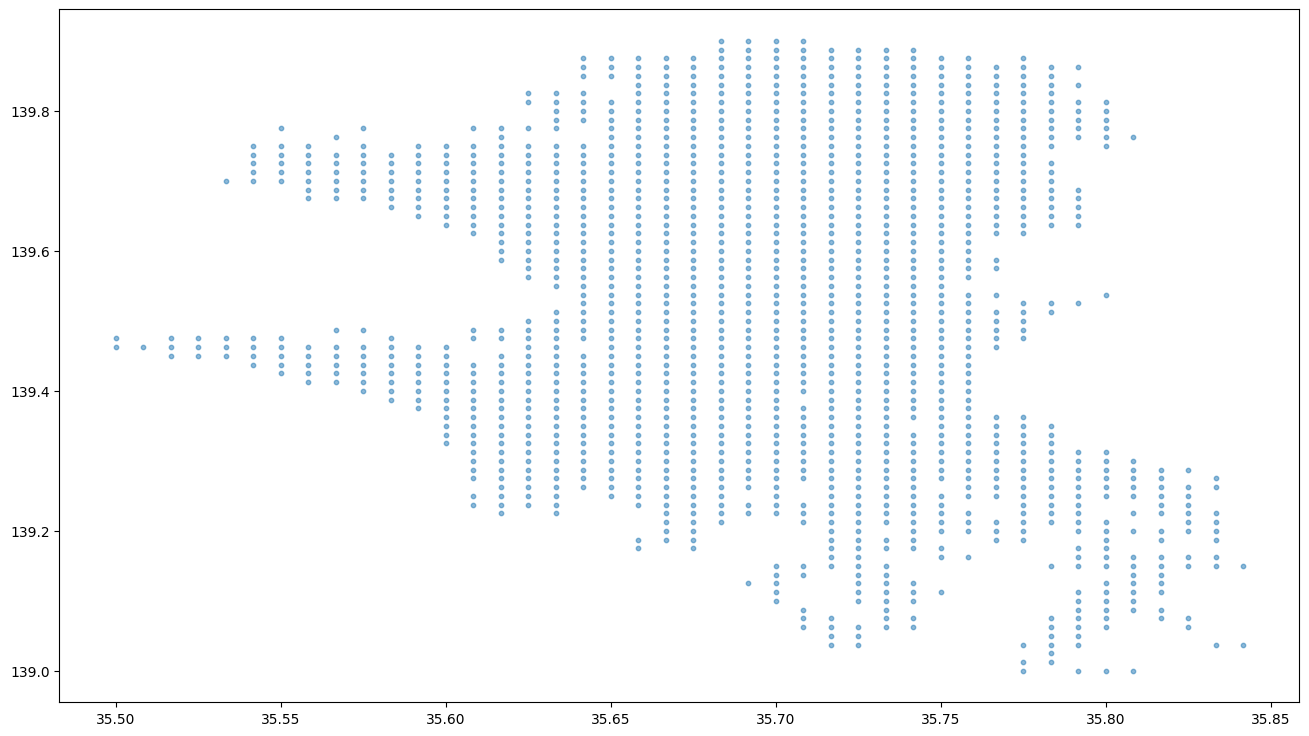

In [ ]:
plt.figure(figsize=(16, 9))
plt.scatter(all_features['latitude'], all_features['longitude'], s=10, alpha=0.5)
plt.show()

In [ ]:
lat_width = 75 / 9000
lon_height = 0.0125
bottom_lat = 35.5
bottom_lon = 139.4625

In [ ]:
m2 = folium.Map(location=[35.7015082, 139.5221197], zoom_start=10.3) # Higashi-Koganei station

In [ ]:
for coord in zip(all_features['latitude'], all_features['longitude']):
  bottom_left = (coord[0], coord[1])
  top_right = (coord[0] + lat_width, coord[1] + lon_height)
  folium.Rectangle(bounds=[bottom_left, top_right], color='blue', fill=True, fill_color='blue').add_to(m2)

In [ ]:
m2

In [ ]:
m2.save('data/mesh_locations.html')

The population data was downloaded only for the city of Tokyo; the physical data were downloaded for a mesh that included parts of Kanagawa and Shizuoka. Their intersection includes the 1378 rows of Tokyo.

In [ ]:
shelter_locations = read_pickle('shelter_locations')
shelter_locations

,municipality_code,ward,num,name,address,flood,landslide,storm,earthquake,tsunami,fire,inland_flooding,volcano,address_match,latitude,longitude
0,13101,東京都千代田区,1,神田一橋中学校,東京都千代田区一ツ橋2-6-14,True,True,False,True,False,False,True,False,True,35.694133,139.756774
1,13101,東京都千代田区,2,都立日比谷高校,東京都千代田区永田町2-16-1,False,False,False,True,False,False,False,False,True,35.676144,139.740509
2,13101,東京都千代田区,3,昌平童夢館,東京都千代田区外神田3-4-7,False,True,True,True,False,False,True,False,True,35.701205,139.769863
3,13101,東京都千代田区,4,旧アーツ千代田３３３１,東京都千代田区外神田6-11-14,False,False,True,True,False,False,True,False,True,35.704257,139.770820
4,13101,東京都千代田区,5,岩本町ほほえみプラザ,東京都千代田区岩本町2-15-3,False,False,False,True,False,False,True,False,True,35.694391,139.777944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053,13421,東京都小笠原村,5,扇浦交流センター,東京都小笠原村父島字扇浦,True,True,True,True,True,True,False,False,True,27.071297,142.202643
2054,13421,東京都小笠原村,6,母島診療所駐車場,東京都小笠原村母島字元地,True,False,True,True,True,True,False,False,True,26.641853,142.158843
2055,13421,東京都小笠原村,7,母島小中学校,東京都小笠原村母島字元地,True,False,True,False,False,True,False,False,True,26.642088,142.160812
2056,13421,東京都小笠原村,8,母島支所,東京都小笠原村母島字元地,True,True,True,False,False,True,False,False,True,26.640577,142.160742


In [ ]:
all_features['shelter_count'] = 0

In [ ]:
shelters_missing_meshes = pd.DataFrame()

In [ ]:
for _, row in shelter_locations.iterrows():
  x_disp = (row['latitude'] - bottom_lat) // lat_width
  y_disp = (row['longitude'] - bottom_lon) // lon_height
  lat_pred, lon_pred = bottom_lat + (x_disp * lat_width), bottom_lon + (y_disp * lon_height)

  row_match_index = (abs(all_features['latitude'] - lat_pred) < 0.001) & (abs(all_features['longitude'] - lon_pred) < 0.001)
  # Account for any floating point round off

  if row_match_index.any():
    all_features.loc[row_match_index, 'shelter_count'] += 1
  else:
    # Oh no
    shelters_missing_meshes = pd.concat([shelters_missing_meshes, row.to_frame().T], ignore_index=True)

In [ ]:
all_features[all_features['shelter_count'] != 0]

,mesh_id,latitude,longitude,area,rice_paddy,other_agriculture,forest,wasteland,building,road_transport,...,dist_to_water,admin_code,2015,total,0-14,15-64,65+,75+,80+,shelter_count
0,53392307,35.50000,139.4625,1047954,0.0,0.00,0.05,0.0,0.739999,0.05,...,0.000000,13209,8133.3263,8428.9629,1125.1046,5516.7014,1787.1569,972.5568,536.7875,1
2,53392317,35.50833,139.4625,1047847,0.0,0.00,0.00,0.0,0.940001,0.03,...,0.000000,13209,9147.2431,9151.1161,1192.9315,6033.2625,1924.9220,1212.4851,808.1996,2
4,53392327,35.51667,139.4625,1047740,0.0,0.05,0.00,0.0,0.880001,0.01,...,925.174449,13209,12250.3348,12274.6534,1340.3404,7578.0816,3356.2314,2048.7194,1272.4508,2
5,53392328,35.51667,139.4750,1047732,0.0,0.00,0.02,0.0,0.909999,0.02,...,924.062776,13209,6280.9909,6157.1817,662.0606,3537.7629,1957.3583,1285.9166,818.6265,2
6,53392336,35.52500,139.4500,1047641,0.0,0.00,0.00,0.0,0.900000,0.00,...,0.000000,13209,11168.1763,11040.2073,1205.7114,6770.1938,3064.3021,1946.8135,1265.4212,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1360,53395663,35.80000,139.7875,1043903,0.0,0.01,0.00,0.0,0.850000,0.05,...,0.000000,13121,12190.1114,11348.2179,1085.5323,6741.5237,3521.1619,2354.3856,1548.7055,1
1361,53395664,35.80000,139.8000,1043897,0.0,0.00,0.00,0.0,0.860000,0.04,...,0.000000,13121,12418.9191,11436.9742,1077.6052,6894.8746,3464.4944,2205.6700,1396.9167,1
1363,53395671,35.80833,139.7625,1043809,0.0,0.01,0.00,0.0,0.910001,0.01,...,0.000000,13121,13027.2710,12804.5451,1473.9617,8331.6438,2998.9396,1937.5985,1150.5506,1
1365,53395710,35.75833,139.8750,1044399,0.0,0.04,0.00,0.0,0.330000,0.01,...,0.000000,13122,1704.9060,1582.2488,158.6083,961.4242,462.2163,282.0519,179.0330,1


In [ ]:
all_features.to_pickle('data/all_features.pkl')

In [ ]:
shelters_missing_meshes

,municipality_code,ward,num,name,address,flood,landslide,storm,earthquake,tsunami,fire,inland_flooding,volcano,address_match,latitude,longitude
0,13119,東京都板橋区,22,三園小学校,東京都板橋区三園1-24-1,True,False,False,True,False,False,False,False,False,35.790335,139.637488
1,13120,東京都練馬区,94,大泉学園桜中学校,東京都練馬区大泉学園町9-2-1,True,False,False,True,False,True,True,False,True,35.777131,139.591963
2,13120,東京都練馬区,95,大泉学園桜小学校,東京都練馬区大泉学園町9-2-2,True,False,False,True,False,True,True,False,True,35.777442,139.590861
3,13120,東京都練馬区,117,八坂中学校,東京都練馬区土支田4-47-21,False,False,False,True,False,True,False,False,True,35.769759,139.612139
4,13120,東京都練馬区,118,八坂小学校,東京都練馬区土支田4-48-1,False,False,False,True,False,True,False,False,True,35.768765,139.611333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,13421,東京都小笠原村,5,扇浦交流センター,東京都小笠原村父島字扇浦,True,True,True,True,True,True,False,False,True,27.071297,142.202643
85,13421,東京都小笠原村,6,母島診療所駐車場,東京都小笠原村母島字元地,True,False,True,True,True,True,False,False,True,26.641853,142.158843
86,13421,東京都小笠原村,7,母島小中学校,東京都小笠原村母島字元地,True,False,True,False,False,True,False,False,True,26.642088,142.160812
87,13421,東京都小笠原村,8,母島支所,東京都小笠原村母島字元地,True,True,True,False,False,True,False,False,True,26.640577,142.160742


In [ ]:
m1 = folium.Map(location=[bottom_lat, bottom_lon], zoom_start=11)

In [ ]:
for coord in zip(shelters_missing_meshes['latitude'], shelters_missing_meshes['longitude']):
  folium.Marker(location=coord).add_to(m1)

In [ ]:
for coord in zip(shelters_missing_meshes['latitude'], shelters_missing_meshes['longitude']):
  folium.Marker(location=coord).add_to(m2)

In [ ]:
m1

In [ ]:
m2

## Final Data Preprocessing

```python
x.shape = (N, F)
adj.shape = (N, N)
y.shape = (N, 1)
```

In [ ]:
all_features = read_pickle('all_features')
features = all_features.drop(['mesh_id', 'latitude', 'longitude', 'area', 'admin_code', '2015', 'total'], axis=1)
features

,rice_paddy,other_agriculture,forest,wasteland,building,road_transport,rail_transport,other_site,river_wetland,seashore,sea,golf_course,unknown,dist_to_water,0-14,15-64,65+,75+,80+,shelter_count
0,0.00,0.00,0.05,0.00,0.739999,0.05,0.04,0.07,0.05,0.0,0.0,0.00,0.0,0.000000,1125.1046,5516.7014,1787.1569,972.5568,536.7875,1
1,0.00,0.15,0.04,0.00,0.680000,0.11,0.00,0.02,0.00,0.0,0.0,0.00,0.0,1133.933309,416.3255,2249.2543,726.4682,392.1746,239.3943,0
2,0.00,0.00,0.00,0.00,0.940001,0.03,0.00,0.00,0.03,0.0,0.0,0.00,0.0,0.000000,1192.9315,6033.2625,1924.9220,1212.4851,808.1996,2
3,0.00,0.02,0.00,0.00,0.880001,0.01,0.00,0.07,0.02,0.0,0.0,0.00,0.0,0.000000,1168.1542,5368.2292,1770.8576,1078.1972,652.0640,0
4,0.00,0.05,0.00,0.00,0.880001,0.01,0.00,0.06,0.00,0.0,0.0,0.00,0.0,925.174449,1340.3404,7578.0816,3356.2314,2048.7194,1272.4508,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373,0.00,0.05,0.86,0.08,0.010000,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,1459.941257,1.4179,4.0062,9.8440,6.1216,5.1849,0
1374,0.00,0.03,0.91,0.04,0.020000,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,1849.483501,0.0000,0.0000,0.0000,0.0000,0.0000,0
1375,0.00,0.00,1.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,2773.751808,0.7987,8.0011,5.1132,3.2897,2.3840,0
1376,0.03,0.14,0.63,0.00,0.030000,0.00,0.00,0.04,0.00,0.0,0.0,0.13,0.0,1459.296689,7.3651,75.4651,85.4520,57.0754,35.6905,0


In [ ]:
# Normalize non-land usage parameters across the columns
def normalize_column(column):
  min_value = column.min()
  max_value = column.max()
  return (column - min_value) / (max_value - min_value)

columns_to_normalize = ['dist_to_water', '0-14', '15-64', '65+', '75+', '80+', 'shelter_count']
features[columns_to_normalize] = features[columns_to_normalize].apply(normalize_column)
features

,rice_paddy,other_agriculture,forest,wasteland,building,road_transport,rail_transport,other_site,river_wetland,seashore,sea,golf_course,unknown,dist_to_water,0-14,15-64,65+,75+,80+,shelter_count
0,0.00,0.00,0.05,0.00,0.739999,0.05,0.04,0.07,0.05,0.0,0.0,0.00,0.0,0.000000,0.266338,0.235879,0.205851,0.187534,0.169839,0.125
1,0.00,0.15,0.04,0.00,0.680000,0.11,0.00,0.02,0.00,0.0,0.0,0.00,0.0,0.190556,0.098554,0.096172,0.083677,0.075621,0.075744,0.000
2,0.00,0.00,0.00,0.00,0.940001,0.03,0.00,0.00,0.03,0.0,0.0,0.00,0.0,0.000000,0.282395,0.257966,0.221719,0.233799,0.255713,0.250
3,0.00,0.02,0.00,0.00,0.880001,0.01,0.00,0.07,0.02,0.0,0.0,0.00,0.0,0.000000,0.276529,0.229531,0.203974,0.207904,0.206312,0.000
4,0.00,0.05,0.00,0.00,0.880001,0.01,0.00,0.06,0.00,0.0,0.0,0.00,0.0,0.155474,0.317290,0.324018,0.386583,0.395046,0.402601,0.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373,0.00,0.05,0.86,0.08,0.010000,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.245341,0.000336,0.000171,0.001134,0.001180,0.001640,0.000
1374,0.00,0.03,0.91,0.04,0.020000,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.310803,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
1375,0.00,0.00,1.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.466124,0.000189,0.000342,0.000589,0.000634,0.000754,0.000
1376,0.03,0.14,0.63,0.00,0.030000,0.00,0.00,0.04,0.00,0.0,0.0,0.13,0.0,0.245232,0.001743,0.003227,0.009843,0.011006,0.011292,0.000


In [ ]:
x = features.values
x.shape

(1378, 20)

In [ ]:
y = np.random.randint(1, 6, size=(1378, 1))
y.shape

(1378, 1)

In [ ]:
G = nx.Graph()

In [ ]:
for i, row in all_features.iterrows():
  G.add_node(i, lat=row['latitude'], lon=row['longitude'], **row.drop(['latitude', 'longitude']))

In [ ]:
lat_width = 75 / 9000
lon_height = 0.0125
error = 0.001

In [ ]:
for i, row1 in all_features.iterrows():
  for j, row2 in all_features.iterrows():
    lat_cond = abs(abs(row1['latitude'] - row2['latitude']) - lat_width) < error
    lon_cond = abs(abs(row1['longitude'] - row2['longitude']) - lon_height) < error
    if lat_cond or lon_cond:
       G.add_edge(i, j)

In [ ]:
adj = nx.to_numpy_array(G)
adj.shape

(1378, 1378)

In [ ]:
np.save('data/arrays/x.npy', x)
np.save('data/arrays/y.npy', y)
np.save('data/arrays/adj.npy', adj)

### Viewing randomly generated y

In [ ]:
y = np.load('data/arrays/y.npy')

In [ ]:
y.flatten()

array([4, 3, 1, ..., 4, 1, 3])

In [ ]:
features = read_pickle('all_features')

In [ ]:
colors = ['#264653', '#2A9D8F', '#E9C46A', '#F4A261', '#E76F51', '#581845', '#C70039', '#FF5733', '#FFC300', '#DAF7A6',
          '#457B9D', '#9E2A2B', '#FF5733', '#FFC300', '#7209B7', '#3A0CA3', '#F72585', '#FFBE0B', '#3F681C', '#8EBA42']

In [ ]:
bottom_lat = 35.5
bottom_lon = 139.4625
lat_width = 75 / 9000
lon_height = 0.0125
error = 0.001

In [ ]:
def create_map(features, col):
  m2 = folium.Map(location=[35.7015082, 139.5221197], zoom_start=10.3, tiles='cartodbpositron') # Higashi-Koganei station

  for coord in zip(features['latitude'], features['longitude'], col):
    bottom_left = (coord[0], coord[1])
    top_right = (coord[0] + lat_width, coord[1] + lon_height)

    folium.Rectangle(bounds=[bottom_left, top_right], color=colors[coord[2]],
                     fill=True, fill_color=colors[coord[2]]).add_to(m2)

  return m2

In [ ]:
m3 = create_map(features, y.flatten())
m3

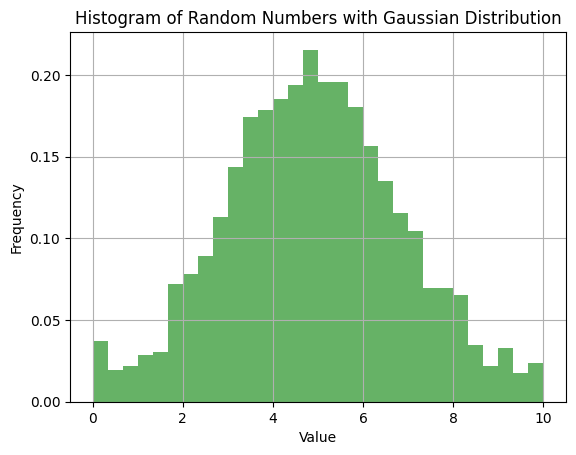

In [ ]:
mean = 5  # Mean of the distribution
std_dev = 2  # Standard deviation of the distribution
num_samples = 1378  # Number of samples

# Generate random numbers
random_numbers = np.random.normal(mean, std_dev, num_samples)

# Clip the random numbers to ensure they fall within the range [0, 10]
random_numbers = np.clip(random_numbers, 0, 10)

# Plot the histogram of the generated random numbers
plt.hist(random_numbers, bins=30, density=True, alpha=0.6, color='g')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Random Numbers with Gaussian Distribution')
plt.grid(True)
plt.show()

In [ ]:
np.sort(random_numbers)

array([ 0.,  0.,  0., ..., 10., 10., 10.])

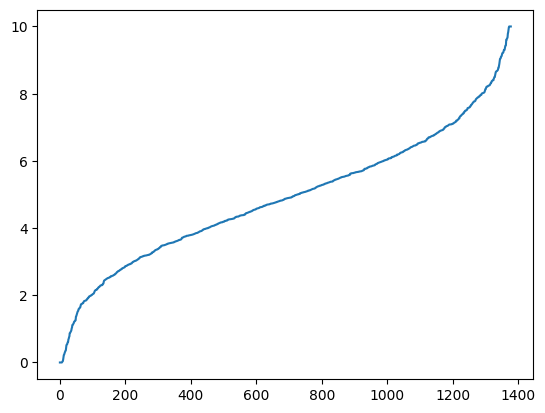

In [ ]:
plt.plot(np.sort(random_numbers))
plt.show()

In [ ]:
random_numbers = np.sort(random_numbers).reshape(-1, 1)
random_numbers

array([[ 0.],
       [ 0.],
       [ 0.],
       ...,
       [10.],
       [10.],
       [10.]])

array([[1.88928572],
       [4.87704178],
       [4.39711664],
       ...,
       [1.90982915],
       [6.16879631],
       [8.26059655]])

In [ ]:
random_numbers.shape

(1378, 1)

In [ ]:
y = random_numbers
np.save('data/arrays/y.npy', y)

In [ ]:
kml_df = gpd.read_file('data/raw_data/jhis_map.kml')
kml_df

DriverError: unsupported driver: 'KML'

In [ ]:
with open('data/raw_data/jhis_map.kml', 'rb') as f:
    kml = f.read()

# Parse the KML content
kml_doc = fastkml.kml.KML()
kml_doc.from_string(kml)

# Extract geometries from KML features
geometries = []
for feature in kml_doc.features():
    if isinstance(feature, fastkml.kml.Placemark):
        geometry = feature.geometry
        if isinstance(geometry, fastkml.geometry.Geometry):
            geometries.append(geometry)

# Extract coordinates from geometries
coords = []
for geometry in geometries:
    if isinstance(geometry, fastkml.geometry.Point):
        coords.append(geometry.coords)
    elif isinstance(geometry, fastkml.geometry.LineString):
        coords.extend(geometry.coords)
    # You can handle other geometry types (Polygon, MultiPoint, etc.) similarly

# Convert coordinates to Points
points = [Point(coord[0], coord[1]) for coord in coords]

# Create GeoDataFrame if points are present
if points:
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=points, crs='EPSG:4326')

    # Plot the GeoDataFrame
    gdf.plot()
else:
    print("No valid geometries found in the KML file.")

No valid geometries found in the KML file.


# Read DBF files

In [1]:
def read_dbf(filepath):
  return gpd.read_file(filepath)

In [7]:
public_locs = read_dbf('public_locs.dbf')
public_locs

,P02_001,P02_002,P02_003,P02_004,P02_005,P02_006,P02_007,geometry
0,13101,3,03001,ニューオータニ美術館,紀尾井町4-1,4,数値地図画像,None
1,13101,3,03001,宮内庁三の丸尚蔵館,千代田1-1,1,数値地図画像,None
2,13101,3,03001,山種美術館,三番町2,4,数値地図,None
3,13101,3,03001,出光美術館,丸の内3-1-1,4,数値地図,None
4,13101,3,03001,独立行政法人国立美術館・東京国立近代美術館,北の丸公園3-1,0,数値地図画像,None
...,...,...,...,...,...,...,...,...
14409,13401,19,19013,末吉保育園,末吉2649,3,数値地図画像,None
14410,13421,19,19013,小笠原村立父島保育園,父島字奥村,3,数値地図画像,None
14411,13382,19,19014,御蔵島村保育園,宮の下,3,数値地図画像,None
14412,13402,19,19014,青ケ島村保育所,None,3,数値地図画像,None
